In [90]:
#%pip install --upgrade pip
# %pip install -q --upgrade jupyter
# %pip install -q pyts
# %pip install -q nbformat>=4.2.0
# %pip show -q ipython
# %pip show -q nbformat
# %pip install -q --upgrade plotly

# %pip install -q yfinance

In [91]:
from __future__ import print_function

import os
import glob
import time

import torch
print(torch.__version__)
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from math import floor

from pyts.image import GramianAngularField
from sklearn.model_selection import KFold
import pandas as pd
from sklearn.preprocessing import StandardScaler,MinMaxScaler
import yfinance as yf

import torch.backends.cudnn

#set gpu env
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device",device)
print("cuda version",torch.version.cuda)

2.3.0+cu121
Device cuda:0
cuda version 12.1


In [92]:
scenario = 0

def Delete_Scenario_Files():
    scenario_files = glob.glob('*scenario*') #find files
    iteration_files = glob.glob('*iteration*')
    optimizer_files = glob.glob('*optimizer*')
    model_files = glob.glob('*model*')

    files_to_delete = scenario_files + iteration_files + optimizer_files + model_files
    files_to_delete = [file for file in files_to_delete if file != 'model_card.md']
    
    for file in files_to_delete:
        try:
            os.remove(file)
            print(f"Deleted {file}")
        except OSError as e:
            print(f"Error deleting {file}: {e}")

def Save_BayesOpt_Model(scenario, net):
    PATH = f'./model_bayesOpt_iteration_{scenario}.pth'
    torch.save(net.state_dict(), PATH)

def Save_Scenario_Model(scenario, net):
    PATH = f'./model_scen_{scenario}.pth'
    torch.save(net.state_dict(), PATH)

def Load_Model(net, PATH):
    print("Loading Model")
    net.load_state_dict(torch.load(PATH))
    net.eval()
    return net

def Clear_Scenario_Log(scenario):
    with open(f'scenario_{scenario}.txt', 'w') as file:
        file.write('')

def Scenario_Log(output_string):
    with open(f'scenarios_output.txt', 'a') as file:
        file.write('\n\n' + output_string)

def Load_BayesOpt_Model(scenario, net):
    PATH = f'./bayesian_optimization_saved_models/model_bayesOpt_iteration_{scenario}.pth'
    print("path model is ",PATH)
    net.load_state_dict(torch.load(PATH))
    net.eval()
    return net


#Delete_Scenario_Files()

## Import Financial Data

In [93]:
#close price time period
start_date = '2021-10-01'
#start_date = '2023-01-01'
end_date = '2023-12-01'

In [94]:
ticker = 'SIVBQ'
dataset = yf.download(ticker, start=start_date, end=end_date, interval='1d')

print("num rows",dataset.shape[0])
# pd.set_option('display.max_rows', None)
# pd.set_option('display.max_columns', None)
# pd.set_option('display.width', None)
# pd.set_option('display.max_colwidth', None)
dataset = dataset.dropna().dropna()
#print("Num rows for df Close col",len(dataset['Close'].dropna()))
print("Num rows for df Close col",len(dataset['Close']))
print(dataset.head())
#print(dataset.iloc[521],dataset.iloc[522],dataset.iloc[523])
# pd.reset_option('display.max_rows')
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')
# pd.reset_option('display.max_colwidth')

[*********************100%%**********************]  1 of 1 completed

num rows 524
Num rows for df Close col 524
                  Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2021-10-01  650.000000  669.570007  648.065002  664.530029  664.530029  281112
2021-10-04  663.989990  669.000000  645.729797  649.349976  649.349976  340741
2021-10-05  657.909973  669.174988  652.072571  665.380005  665.380005  358684
2021-10-06  654.039978  663.919983  643.219971  659.849976  659.849976  441251
2021-10-07  670.929993  679.000000  663.280029  665.559998  665.559998  258661


[*********************100%%**********************]  1 of 1 completed

SVB num rows 524
S&P Financials num rows 545
SVB data head:
                   Open        High         Low       Close   Adj Close  Volume
Date                                                                          
2021-10-01  650.000000  669.570007  648.065002  664.530029  664.530029  281112
2021-10-04  663.989990  669.000000  645.729797  649.349976  649.349976  340741
2021-10-05  657.909973  669.174988  652.072571  665.380005  665.380005  358684
2021-10-06  654.039978  663.919983  643.219971  659.849976  659.849976  441251
2021-10-07  670.929993  679.000000  663.280029  665.559998  665.559998  258661
S&P Financials data head:
                   Open        High         Low       Close   Adj Close  \
Date                                                                     
2021-10-01  624.599976  639.010010  624.059998  634.539978  634.539978   
2021-10-04  634.539978  642.070007  628.369995  629.859985  629.859985   
2021-10-05  629.859985  644.270020  629.859985  641.039978  641

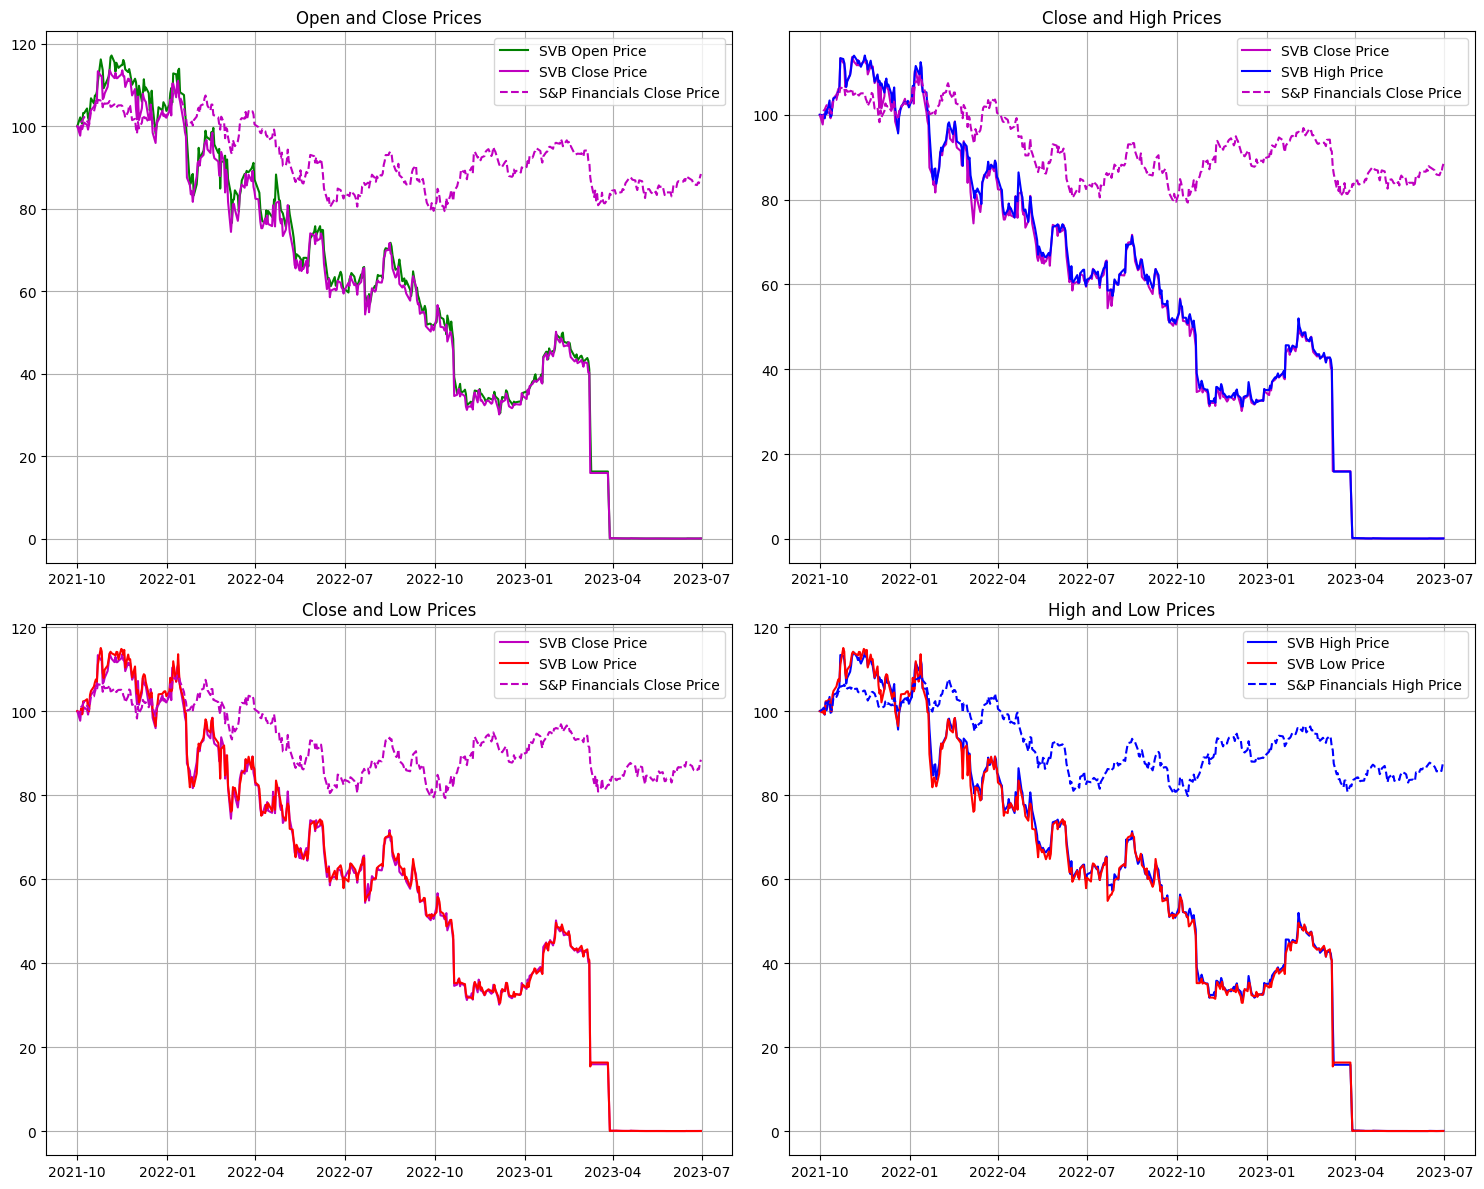

In [95]:
sp_financials_ticker = '^SP500-40'
sp_financials_data = yf.download(sp_financials_ticker, start=start_date, end=end_date, interval='1d')

print("SVB num rows", dataset.shape[0])
print("S&P Financials num rows", sp_financials_data.shape[0])
print("SVB data head:\n", dataset.head())
print("S&P Financials data head:\n", sp_financials_data.head())

# Drop rows with any missing values
svb_data = dataset.dropna()
sp_financials_data = sp_financials_data.dropna()

# Filter data up to 1 July 2023
svb_data = svb_data[svb_data.index <= '2023-07-01']
sp_financials_data = sp_financials_data[sp_financials_data.index <= '2023-07-01']

# Rebase prices to 100
svb_rebased = svb_data / svb_data.iloc[0] * 100
sp_financials_rebased = sp_financials_data / sp_financials_data.iloc[0] * 100

# Create a grid of 2x2 subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 12))

# Plot Open and Close prices
axs[0, 0].plot(svb_rebased.index, svb_rebased['Open'], label='SVB Open Price', color='g')
axs[0, 0].plot(svb_rebased.index, svb_rebased['Close'], label='SVB Close Price', color='m')
axs[0, 0].plot(sp_financials_rebased.index, sp_financials_rebased['Close'], label='S&P Financials Close Price', color='m', linestyle='--')
axs[0, 0].set_title('Open and Close Prices')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Plot Close and High prices
axs[0, 1].plot(svb_rebased.index, svb_rebased['Close'], label='SVB Close Price', color='m')
axs[0, 1].plot(svb_rebased.index, svb_rebased['High'], label='SVB High Price', color='b')
axs[0, 1].plot(sp_financials_rebased.index, sp_financials_rebased['Close'], label='S&P Financials Close Price', color='m', linestyle='--')
axs[0, 1].set_title('Close and High Prices')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Plot Close and Low prices
axs[1, 0].plot(svb_rebased.index, svb_rebased['Close'], label='SVB Close Price', color='m')
axs[1, 0].plot(svb_rebased.index, svb_rebased['Low'], label='SVB Low Price', color='r')
axs[1, 0].plot(sp_financials_rebased.index, sp_financials_rebased['Close'], label='S&P Financials Close Price', color='m', linestyle='--')
axs[1, 0].set_title('Close and Low Prices')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Plot High and Low prices
axs[1, 1].plot(svb_rebased.index, svb_rebased['High'], label='SVB High Price', color='b')
axs[1, 1].plot(svb_rebased.index, svb_rebased['Low'], label='SVB Low Price', color='r')
axs[1, 1].plot(sp_financials_rebased.index, sp_financials_rebased['High'], label='S&P Financials High Price', color='b', linestyle='--')
axs[1, 1].set_title('High and Low Prices')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout
plt.tight_layout()
plt.show()

## Clean dataset

Drop row if column is either NaN or missing

In [96]:
dataset.dropna(how='any', inplace=True)

## Imaging Algorithm: Generate Gramian angular field (GAF) images from time series data 
Uses popular time series imaging algorithm in [pyts' GramianAngularField method](https://pyts.readthedocs.io/en/stable/auto_examples/image/plot_single_gaf.html)

GAF represents time series in a polar coordinate system instead of the typical Cartesian coordinates by considering the trigonometric sum or difference between stock prices and calculate the correlation within different time intervals. [Source.](https://towardsdatascience.com/rgb-gaf-image-a-possible-solution-to-one-weak-point-of-gramian-angular-field-imaging-ffc6b31edfbe)

[Making Gram matrix CNN ready](https://medium.com/analytics-vidhya/encoding-time-series-as-images-b043becbdbf3)

Gramian Matrix of a set of n vectors:

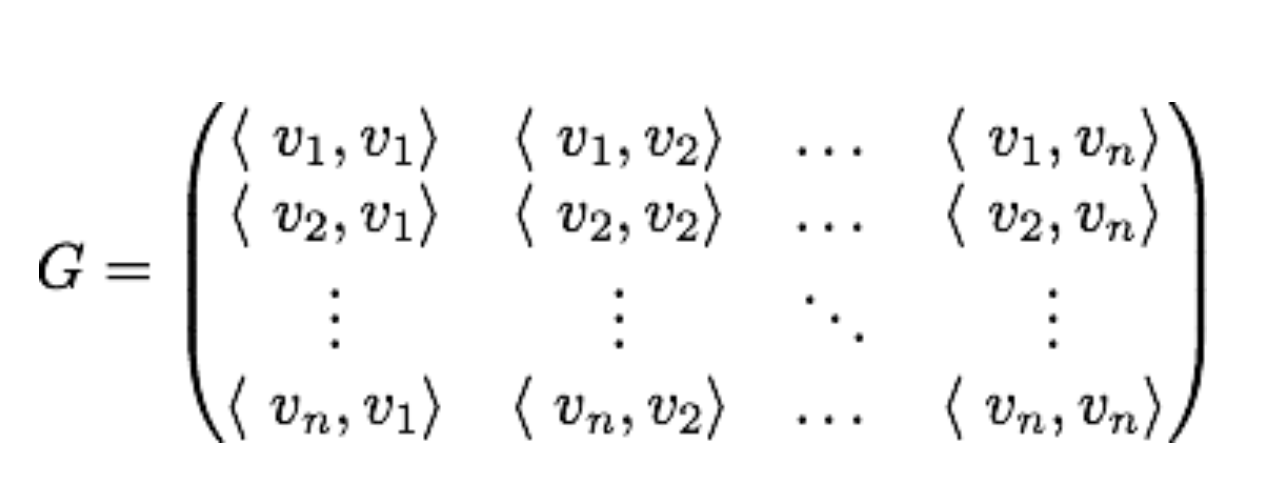

Gramian Matrix of units vector where Φ(i, j) is the angle between vectors i and j

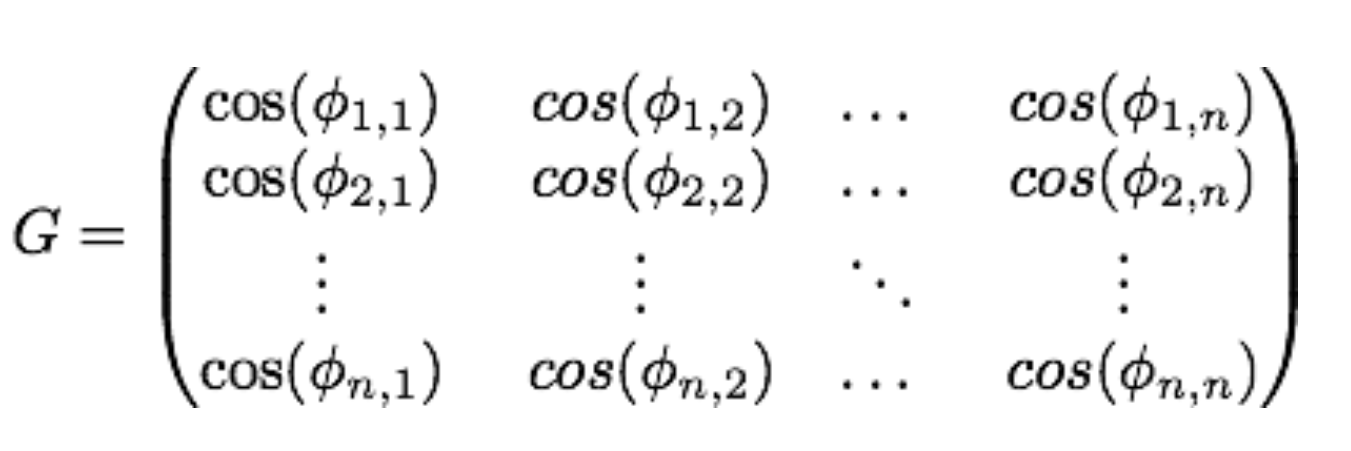

Therefore the dot product operation in GAF provides us with the correlation between each set of observations whilst preserving the temporal relationship. To account for the bias introduced from the inner product between two distinct observations or an observation with itself, a further summation or difference matrix (GASF or GADF) transformation is applied. In this notebook we apply summation.

Since GAF provides the combination of the datapoints requested, each image of size 32 in this notebook, the dot product combination of 32 data points yields 1024 points in an image (32x32 image). Since we request GAF images of size 32x32, we can calculate the number of images GAF will generate for one feature (e.g. closing price time series), in the example images below 524 data points / 32 = 16 images; thus 524 data points yield 16,384 gaf values represented over 16 images size 32x32.

In [97]:
def generate_gaf_images(dataset, gaf_img_sz=32, method="summation", sample_range=(0,1)):
    #print("len data series received:",len(dataset),"size",dataset.size)

    #determine num of gaf_img_szX images with gaf_img_sz datapoints
    num_images_to_generate = floor(len(dataset) / gaf_img_sz)
    #print("len dataset",len(dataset),"num_images_to_generate",num_images_to_generate)
    
    #reshape dataset into number of images
    dataset = dataset[:num_images_to_generate*gaf_img_sz].reshape(num_images_to_generate, gaf_img_sz)
    #print("data in GAF",dataset)
    
    #TODO: Explore label set according to each feature
    #print("num_images_to_generate","dataset 1",dataset[1])
    mean_price_list=[]
    for i in range(num_images_to_generate):
        mean_price_list.append(np.mean(dataset[i]))
        #print("Num images to generate",num_images_to_generate,"Dataset mean",np.mean(dataset[i]),"dataset",dataset)
    #print("prices in GAF",price_list)
    #print("image_size",gaf_img_sz)
    
    gaf = GramianAngularField(image_size=gaf_img_sz, method=method, sample_range=sample_range)
    gaf_images= gaf.fit_transform(dataset)
    #print("gaf_image",gaf_images.shape)
    #print("returning price list",mean_price_list)
    
    return gaf_images, mean_price_list

## Visualize Closing Price for one image in GAF
A darker patch indicates lower correlation between the different elements of the price time series, possibly due to higher volatility or noise. The opposite is true for the lighter patches.

524
len datapoints in dataset 524
 (16, 32, 32)
gaf_images.shape (16, 32, 32) data points in images 16384 gaf image [0] shape (32, 32) data points in image [0] 1024


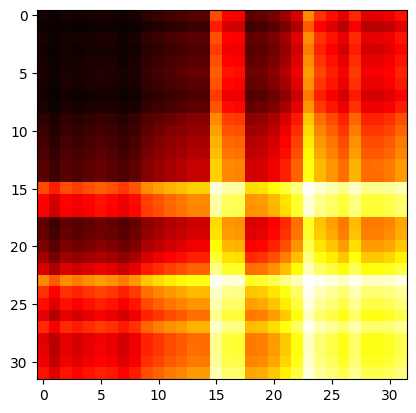

In [98]:
gaf_method='summation'

full_feature_data = np.array(dataset['Close'])
print(len(dataset['Close']))
#print("feature_dataset_array",feature_data)
print("len datapoints in dataset",len(full_feature_data))

np.set_printoptions(threshold=np.inf)
gaf_images, mean_price_list= generate_gaf_images(full_feature_data,gaf_img_sz=32, method=gaf_method)

print("",gaf_images.shape)
plt.imshow(gaf_images[0],cmap='hot')
print("gaf_images.shape",gaf_images.shape,"data points in images",gaf_images.size, "gaf image [0] shape",gaf_images[0].shape, "data points in image [0]",gaf_images[0].size)
#print("gasf image[0] data",gaf_images[0])
#print("Gasf data",gasf_images)

np.set_printoptions()

## Generate images for open, high, low, close and adj close prices

We transpose the resulting image list to represent:
+ 16: number of images
+ 5: number of image channels/features. Each image has 5 ="Open", "High", "Low", "Close", and "Adj Close"
+ 32: image height
+ 32: image width
+ the label is the 32+1 price for each time series chunk (image) corresponding to the relevant feature

In [99]:
np.set_printoptions(threshold=np.inf)

cols_used = ["Open", "High", "Low", "Close", "Adj Close"]
cols_used_count = sum(column_name in cols_used for column_name in dataset.columns)

#TODO: Instead of insert a list in each list for each feature, insert the elements directly
def generate_multiple_feature_images(dataset, image_size=32, method="summation", sample_range = (0, 1)):
    
    feature_image_dataset_list=[[] for _ in range(len(cols_used))]
    feature_price_dataset_list=[[] for _ in range(len(cols_used))] #="Open", "High", "Low", "Close" , "Adj Close"
    feature_label_dataset_list=[] #next value for each chunk of ="Open", "High", "Low", "Close" , "Adj Close"
    column_idx = 0

    for idx, column_name in enumerate(dataset.columns):

      #create open, high, low and close images
      if column_name in ["Open", "High", "Low", "Close", "Adj Close"]:
        temp_image_list = []
        temp_price_list = []
        temp_label_list = []
        #print("dataset idx", idx, "len rows this data feature", len(dataset[i]), "dataset[i].shape", dataset[i].shape, "dataset i:", dataset[i])

        full_feature_data = dataset[column_name].values
        full_feature_num_samples = len(full_feature_data)
        print("full_feature_num_samples",full_feature_num_samples)

        num_windows = image_size
        #add 1 for last window label
        window_size = full_feature_num_samples - (image_size + 1)

        #loop by data_chunk so each chunk represents the price series that we slide by one day forward
        # TODO: parallelism
        for curr_window_index in range(num_windows):
          
          curr_sliding_window_data = full_feature_data[curr_window_index:window_size+curr_window_index]

          #print(f"Curr window len {len(curr_sliding_window_data)} first value {curr_sliding_window_data[0]} next value {curr_sliding_window_data[1]} last value {curr_sliding_window_data[490]}")
          
          target_num_chunks = floor(window_size / image_size)
          #print(f"Target number of chunks for curr Window {column_name}",target_num_chunks)
          
          for cur_chunk in range(target_num_chunks):
            #print("cur_chunk",cur_chunk)
            
            #chunk size of image size
            data_chunk = curr_sliding_window_data[cur_chunk*image_size:(cur_chunk*image_size)+image_size]
            #if (cur_chunk == 31 or cur_chunk == 32):
              #print("cur_chunk",cur_chunk,"data chunk",data_chunk)
            #append gaf image to image list. store price feature values in price list
            gaf_images, price_list = generate_gaf_images(data_chunk, gaf_img_sz=image_size, method=method, sample_range=sample_range)
            temp_image_list.append(gaf_images)
            #***print("At chunk",cur_chunk,"input chunk size",len(data_chunk),"shape gaf images",gaf_images.shape, "len temp image list",len(temp_image_list))
            
            # if(cur_chunk==0):
            #   print("Price Data Pre-Gaf: i", cur_chunk, "len",len(data_chunk), "shape", feature_data.shape, "data",data_chunk)
            #   print("Image Returned: idx", idx, "image size", gaf_images.size, f"first {image_size} image vals", gaf_images.flatten()[:image_size])
            
            temp_price_list.append(price_list)
            #print("At chunk",cur_chunk,"input chunk size",len(data_chunk),"len price_list",len(price_list),price_list)
            
            #get next single value after the chunk as label to list
            #print("appending to temp label list",feature_data[cur_chunk + image_size + 1])
            temp_label_list.append(full_feature_data[cur_chunk + image_size + 1])
            #feature_label_index_dataset_list.append(feature_data[cur_chunk + image_size + 1])
            #print("chunk",cur_chunk,"label for",column_name,"price",feature_data[cur_chunk + image_size + 1])
            #if(column_name == "Open"):
              #index position for the label of this chunk
              #feature_label_index_dataset_list.append(cur_chunk + image_size + 1)
              #print("at chunk",cur_chunk,"feature label list",feature_label_index_dataset_list)
        
        print(f"Column {column_name} temp image list len to append",len(temp_image_list))
        feature_image_dataset_list[column_idx].append(temp_image_list)
        #print("feature_image_dataset_list",feature_image_dataset_list)
        feature_price_dataset_list[column_idx].append(temp_price_list)
        #print("price list",price_list)
        feature_label_dataset_list.append(temp_label_list)
        column_idx += 1

    # print("Final len images",len(feature_image_dataset_list),
    #        "len image list index (i.e. feature) 0",len(feature_image_dataset_list[0][0]))
    # print("Final len price list",len(feature_price_dataset_list),
    #        "len feature_price_dataset_list index 0 (i.e. column 0)", len(feature_price_dataset_list[0][0]),feature_price_dataset_list)
    # print("Final len labels", len(feature_label_dataset_list),feature_label_dataset_list) # 2455=total range*5
    
    feature_image_dataset_list = np.array(feature_image_dataset_list) 
    #print("Final Shape of images before transpose:", feature_image_dataset_list.shape)
    
    #transpose image for CNN
    #(5, 1, 491, 1, 32, 32)
    feature_image_dataset_list= np.transpose(feature_image_dataset_list, (1, 3, 0, 2, 4, 5))
    #print("Final Shape of images after transpose:", feature_image_dataset_list.shape)

    return feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list

#Generate images from dataset
gaf_method="summation"
sample_range = (0, 1)
image_size = 32 #(x,y)
feature_image_dataset_list, feature_price_dataset_list, feature_label_dataset_list = generate_multiple_feature_images(dataset, image_size=image_size, method=gaf_method, sample_range=sample_range)

print("shape [0] set",np.array(feature_image_dataset_list[0]).shape)

np.set_printoptions()

full_feature_num_samples 524
Column Open temp image list len to append 480
full_feature_num_samples 524
Column High temp image list len to append 480
full_feature_num_samples 524
Column Low temp image list len to append 480
full_feature_num_samples 524
Column Close temp image list len to append 480
full_feature_num_samples 524
Column Adj Close temp image list len to append 480
shape [0] set (1, 5, 480, 32, 32)


## Visual representation of feature images for the same time range

Bottom image averages depth values of feature images (channels)

shape images array (1, 1, 5, 480, 32, 32) shape image (32, 32)


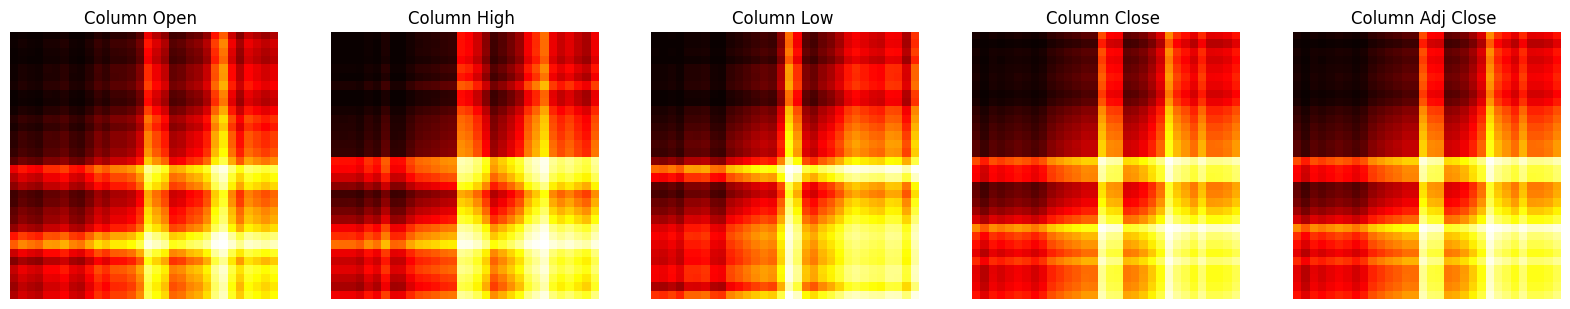

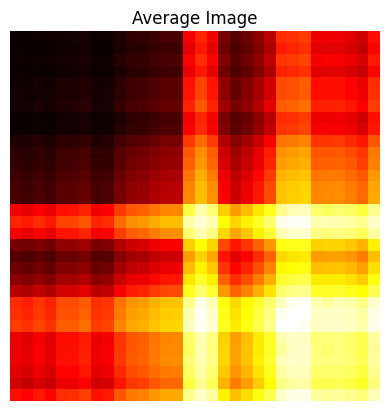

In [100]:
images_array=np.array(feature_image_dataset_list)
prices_array=np.array(feature_price_dataset_list) #not used
labels_array=np.array(feature_label_dataset_list)
#print("len price array",len(prices_array),prices_array.shape,prices_array)
#print("images_array",len(images_array[0][0][0]),"labels_array",len(labels_array[0]),"prices array",len(prices_array[0][0]))
#print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
#print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])

# Plot the first image of each column
fig, axes = plt.subplots(nrows=1, ncols=cols_used_count, figsize=(20, 6))
for ax in axes:
    ax.set_aspect('equal')

#EXPLANATION SHAPE
#shape images array (1, 1, 5, 480(=15 chunks * 32 windows), 32, 32)
#I get 15 images (32x32) for 491 data points (491 = 524 - 33 data points for sliding windows, i.e. 32+1 for label)
#I create 32*15=480 32x32images
#print("image",images_array[0])
print("shape images array",images_array.shape,"shape image",images_array[0][0][0][0].shape)
for i in range(cols_used_count):
    axes[i].imshow(images_array[0][0][i][0], cmap='hot')
    axes[i].set_title(f"Column {cols_used[i]} ")

#average first image of all features
average_images = []
for i in range(cols_used_count):
    average_images.append(images_array[0][0][i][0])

average_image = np.mean(average_images, axis=0)

# Hide axes
for ax in axes:
    ax.axis('off')

# Plot the average image separately
plt.figure()  # Create a new figure for the average image
plt.imshow(average_image, cmap='hot')
plt.title("Average Image")
plt.axis('off')  # Hide axes
plt.show()

In [101]:
#squeeze arrays
images_array = images_array.squeeze(axis=(0, 1))
print("len img",len(images_array),"image shape",images_array.shape)#,"prices_array[0][0]",prices_array[0][0])
print("len label",len(labels_array),"labels shape",labels_array.shape)#,"prices_array[0][0]",prices_array[0][0])


len img 5 image shape (5, 480, 32, 32)
len label 5 labels shape (5, 480)


## Prepare Training/Testing Datasets for Neural Network

Apply Transform to image to convert to tensor and normalize

In [102]:
def SetTransform(normalize_ftor=0.5,resolution_x=32,resolution_y=32):
    return transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([normalize_ftor], [normalize_ftor])
    #transforms.Resize((resolution_x, resolution_y))
    ])

Init Hyper-parameters

In [103]:
#Default hyperparameters

filter_size_1=(2, 3)
filter_size_2=(2, 2)
filter_size_3=(2, 3)

stride=2

output_conv_1=40#180#40
output_conv_2=12#180
output_FC_1=100#40
output_FC_2=70
final_FCLayer_output=1

learning_rate= 0.0001#0.000001#0.000001#0.001#0.000001=0.56;0.00001=0.15
momentum = 0.9

dropout_probab=0

batch_size =5

num_epochs_input = 10000

transform = SetTransform(normalize_ftor=0.5, resolution_x=32, resolution_y=32)

In [104]:
feature_image_dataset_list_f32 = np.array(images_array).astype(np.float32)
feature_image_dataset_list_f32 = feature_image_dataset_list_f32.reshape(-1, image_size, image_size)
#images_array = np.transpose(feature_image_dataset_list, (1, 0, 2, 3))

#scaler = MinMaxScaler()
scaler = StandardScaler()
labels_array = np.array(labels_array)#.astype(np.float32)
#print("labels array",labels_array)
reshaped_labels_array = labels_array.reshape(-1, 1)
#print("reshaped labels array",reshaped_labels_array)
labels_scaled_list_f32 = scaler.fit_transform(reshaped_labels_array).reshape(-1,).astype(np.float32)
#print("scaled labels",labels_scaled_list_f32)
print("4D image array shape",images_array.shape)
print("3D reshaped image array ",feature_image_dataset_list_f32.shape)
print("labels shape",reshaped_labels_array.shape)

4D image array shape (5, 480, 32, 32)
3D reshaped image array  (2400, 32, 32)
labels shape (2400, 1)


Prepare features data (close, high, low, etc) for Dataloader

In [105]:
class DataPrep(Dataset):
    def __init__(self, inputs, labels):
        self.inputs = inputs #all features in one large array
        self.labels = labels
        self.transform = SetTransform()

    def __len__(self):
      return len(self.inputs)

    def __getitem__(self, index):
        X = self.inputs[index]
        Y = self.labels[index]
        return X, Y
  
    def prepare_ordered_dataset(self):
        x = []
        y = []
        #print("len inputs", len(self.inputs), "shape", self.inputs.shape, self.inputs.shape[0])
        #print("len images 0",len(self.inputs), "len images 0:",len(self.inputs[0]))
        #print("images 0:",self.inputs[0])
        #print("labels",self.labels)
        #print("len labels", len(self.labels), self.labels.shape, self.labels.shape[0])
        for image_num in range(self.inputs.shape[0]):
            #print("len image data 0",len(self.inputs[data_window][0]),"shape",self.inputs[data_window].shape)
            #print("label data",self.labels[image_num][0])
            #print("imag num:",image_num)
            #print("image data at index image_num len:",len(self.inputs[image_num]))
            
            self.inputs[image_num] = self.transform(self.inputs[image_num])
            
            x.append(np.expand_dims(self.inputs[image_num], axis=0))
            y.append(self.labels[image_num])
            #print("img num",image_num,"label",self.labels[image_num])
            #print("img num",image_num,"img",self.inputs[image_num])
            #print("img num",image_num,"img len",len(self.inputs[image_num]))
            
        #cnn requests labels size (4,1) instead of (4)
        y = np.expand_dims(y, axis=1) 
        #print("size self",self.inputs.shape,self.labels.shape)
        #print("size self",len(x),len(y))
        dataset = [(img, label) for img, label in zip(x, y)]
        #print("type dataset returned",type(dataset), len(dataset), len(dataset[0]), len(dataset[1]))
        #print("len dataset[0][0]",len(dataset[0][0][0][0]))
        #print("len dataset[1][1]",len(dataset[1][1]))
        #print("dataset[0]",dataset[1])
        return dataset
        
        #return np.array(x),np.array(y)
    
    def split_data(self,dataset, batch_size=batch_size, test_size=0.2, train_shuffle=False):
        num_samples = len(dataset)
        #print("numsamples",num_samples)
        num_test_samples = int(test_size * num_samples)
        num_train_samples = num_samples - num_test_samples
        #print("num_train_samples",num_train_samples)
        indices = np.random.permutation(num_samples)
        train_indices = indices[:num_train_samples]
        test_indices = indices[num_train_samples:]
        print("len train",len(train_indices),"len test",len(test_indices))

        train_sampler = SubsetRandomSampler(train_indices)
        test_sampler = SubsetRandomSampler(test_indices)

        train_loader = DataLoader(dataset, batch_size=batch_size, sampler=train_sampler,shuffle=train_shuffle)
        test_loader = DataLoader(dataset, batch_size=batch_size, sampler=test_sampler)

        #for e in train_loader:
            #print("train loader ele",e)

        # sample_batch = next(iter(train_loader))
        # input_shape = sample_batch[0].shape
        # label_shape = sample_batch[1].shape
        # print("input len",len(input_shape),"input shape",input_shape,"label len",len(label_shape))

        return train_loader, test_loader

In [106]:
def Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, train_shuffle=False, batch_size=batch_size):

    #print("feature_image_dataset_list_f32[0][0].shape",feature_image_dataset_list_f32[0][0].shape, "feature_image_dataset_list_f32[0][0].shape[0]", feature_image_dataset_list_f32[0][0].shape[0])

    #reshape for cnn
    #reshaped_feature_image_dataset_list_f32 = np.expand_dims(feature_image_dataset_list_f32[0][0].reshape(-1, *feature_image_dataset_list_f32[0][0].shape[2:]), axis=1)
    #print("feature_image_dataset_list_f32 shape",feature_image_dataset_list_f32.shape)
    #print("res",reshaped_feature_image_dataset_list_f32.shape)

    #generate a list for images and labels
    data_prep_class = DataPrep(feature_image_dataset_list_f32, labels_scaled_list_f32)

    #print("feature_image_dataset_list_f32",feature_image_dataset_list_f32[0][0].shape)
    #print("labels_scaled_list_f32",labels_scaled_list_f32.shape)
    #returns list size all observations of all features of size 2:
    #(image32x32,label) i.e. shape (5*480,32,32) and (5*480,1)
    dataset = data_prep_class.prepare_ordered_dataset()

    # for c in range(len(dataset[0])):
    #     print(f"size labels {c}",dataset[1][c].size)
    #     print(f"size image {c}",dataset[0][c].shape)

    batch_size = batch_size
    train_loader, test_loader = data_prep_class.split_data(dataset, 
                                                         batch_size=batch_size,
                                                         train_shuffle=train_shuffle)

    # for c,e in enumerate(train_loader):
    #     print("count",c)
        # print("type",type(e))
        # print("imga",e[0].shape)
        # print("label",e[1].shape)
    #returns 191 train_loaders that contain batch of 10 images32x32 and 10 labels
    #=191*10=1910 i.e. 80% of 2400 total
    return train_loader,test_loader
    

train_loader,test_loader = Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, batch_size=batch_size)

len train 1920 len test 480


## CNN Design

dynamically calulate the shape of layers outputs

In [107]:
def conv_output_shape_dynamic(h_w, kernel_size=(1,1), stride=1):
        h = floor( (h_w[0] - kernel_size[0])/ stride) + 1
        w = floor( (h_w[1] - kernel_size[1])/ stride) + 1
        return h, w

In [108]:
class Net(nn.Module):
    def __init__(self,name="LeNet5Blend",
                 filter_size_1=filter_size_1, filter_size_2=filter_size_2, filter_size_3=filter_size_3, stride=stride,
                 output_conv_1=output_conv_1,output_conv_2=output_conv_2, output_FC_1=output_FC_1,output_FC_2=output_FC_2,
                 image_resolution_x=32,image_resolution_y=32,final_FCLayer_outputs=final_FCLayer_output,
                 dropout_probab=dropout_probab):
        super(Net, self).__init__()
        
        if name:
            self.name = name
        self.totalparams = 0
        self.output_conv_2=output_conv_2
        self.conv_output_size=0
        print();print("Convos & dropoutP:",output_conv_1,output_conv_2, dropout_probab)
        
        #num channels input, num channels output, filter size 
        self.conv1 = nn.Conv2d(1, output_conv_1, filter_size_1,stride=1)
        #filtersize,stride.
        #maxpool acts the same way in each channel, so doesn't need to be fed the num channels of the input
        self.pool = nn.MaxPool2d(kernel_size=filter_size_2, stride=stride)
        self.conv2 = nn.Conv2d(output_conv_1, output_conv_2, filter_size_3,stride=1)

        H_out_1, W_out_1 = conv_output_shape_dynamic((image_resolution_y, image_resolution_x), kernel_size=filter_size_1,stride=1)
        H_out_2, W_out_2 = conv_output_shape_dynamic((H_out_1, W_out_1), kernel_size=filter_size_2,stride=stride)
        H_out_3, W_out_3 = conv_output_shape_dynamic((H_out_2, W_out_2), kernel_size=filter_size_3,stride=1)
        H_out_4, W_out_4 = conv_output_shape_dynamic((H_out_3, W_out_3), kernel_size=filter_size_2,stride=stride)
        
        print("imgres",image_resolution_x,image_resolution_y)
        print("H_out_1, W_out_1",H_out_1, W_out_1)
        print("H_out_2, W_out_2",H_out_2, W_out_2)
        print("H_out_3, W_out_4",H_out_3, W_out_3)
        print("H_out_4, W_out_4",H_out_4, W_out_4)
        print("outputconv2",output_conv_2)
        self.conv_output_size = H_out_4 * W_out_4

        #Fully connected layers and apply dropout
        self.fc1 = nn.Linear(output_conv_2*self.conv_output_size, output_FC_1)
        if(dropout_probab>0): self.dropout1 = nn.Dropout(dropout_probab)
        self.fc2 = nn.Linear(output_FC_1, output_FC_2)
        if(dropout_probab>0): self.dropout1 = nn.Dropout(dropout_probab)
        self.fc3 = nn.Linear(output_FC_2, final_FCLayer_outputs)
        
        # compute the total number of parameters
        total_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        print(self.name + ': total params:', total_params)
        self.totalparams=total_params

    def forward(self, x):
        #print("Input shape:", x.shape)
        x = self.pool(F.relu(self.conv1(x)))
        #print("After conv1 and pooling shape:", x.shape)
        x = self.pool(F.relu(self.conv2(x)))
        #print("After conv2 and pooling shape:", x.shape)
        #-1 takes the batch size
        x = x.view(-1,self.output_conv_2*self.conv_output_size)
        #print("After flattening shape:", x.shape)
        x = F.relu(self.fc1(x))
        #print("After fc1 shape:", x.shape)
        x = F.relu(self.fc2(x))
        #print("After fc2 shape:", x.shape)
        x = self.fc3(x)
        #print("Output shape:", x.shape)
        return x

## Train and Test CNN

Init Weights

In [109]:
def weights_init_he(m):
    if isinstance(m, nn.Conv2d):
        #mode=fan_out: Used for convolutional layers to account for the output size of the layer
        nn.init.kaiming_uniform_(m.weight, mode='fan_out', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)
    elif isinstance(m, nn.Linear):
        #mode=fan_in: Used for linear layers to account for the input size
        nn.init.kaiming_uniform_(m.weight, mode='fan_in', nonlinearity='relu')
        if m.bias is not None:
            nn.init.constant_(m.bias, 0)

Plot Gradients and Weights

In [110]:
def plot_data(weights_dict, gradients_dict, epoch):
    for name, weight_list in weights_dict.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Epoch {epoch + 1} - Weights {name}")
        
        for i, w in enumerate(weight_list):
            plt.plot(w.flatten())
        
        plt.xlabel('Weight Index')
        plt.ylabel('Weight Value')
        plt.legend(loc="upper right")
        plt.show()

    for name, gradient_list in gradients_dict.items():
        plt.figure(figsize=(10, 6))
        plt.title(f"Epoch {epoch + 1} - Gradients {name}")
        
        for i, g in enumerate(gradient_list):
            plt.plot(g.flatten())
        
        plt.xlabel('Gradient Index')
        plt.ylabel('Gradient Value')
        plt.legend(loc="upper right")
        plt.show()


Instantiate Net

In [111]:
net = Net(name='Classification Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
            filter_size_3=filter_size_3, stride=stride,
            image_resolution_x=32,image_resolution_y=32,
            output_conv_1=output_conv_1, output_conv_2=output_conv_2,
            output_FC_1=output_FC_1, output_FC_2=output_FC_2,
            final_FCLayer_outputs=final_FCLayer_output,
            dropout_probab=dropout_probab)

def print_layer_weights(model):
    for name, param in model.named_parameters():
        if param.requires_grad and 'weight' in name:
            print(f"{name}: {param.numel()} weights")


net.to(device)
net.parameters()
print_layer_weights(net)


Convos & dropoutP: 40 12 0
imgres 32 32
H_out_1, W_out_1 31 30
H_out_2, W_out_2 15 15
H_out_3, W_out_4 14 13
H_out_4, W_out_4 7 6
outputconv2 12
Classification Net: total params: 60813
conv1.weight: 240 weights
conv2.weight: 2880 weights
fc1.weight: 50400 weights
fc2.weight: 7000 weights
fc3.weight: 70 weights


Train CNN

Train params: learning_rate: 0.0001, momentum:0.9
epoch 0 data i 0 len image 5 shape torch.Size([5, 1, 32, 32])
epoch 0 data i 0 label tensor([[ 0.2661],
        [-1.9130],
        [-0.1430],
        [ 0.3930],
        [-0.1430]], device='cuda:0') labels shape torch.Size([5, 1])
[400,   384] Cum loss: 0.035865
[800,   384] Cum loss: 0.029209
[1200,   384] Cum loss: 0.024983
[1600,   384] Cum loss: 0.024626


C:\Users\Sergio\AppData\Local\Temp\ipykernel_30220\3950198212.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


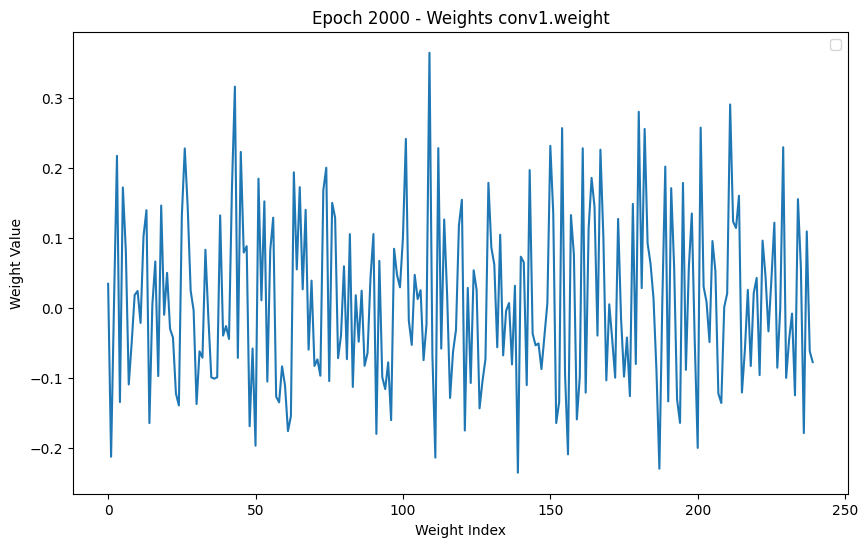

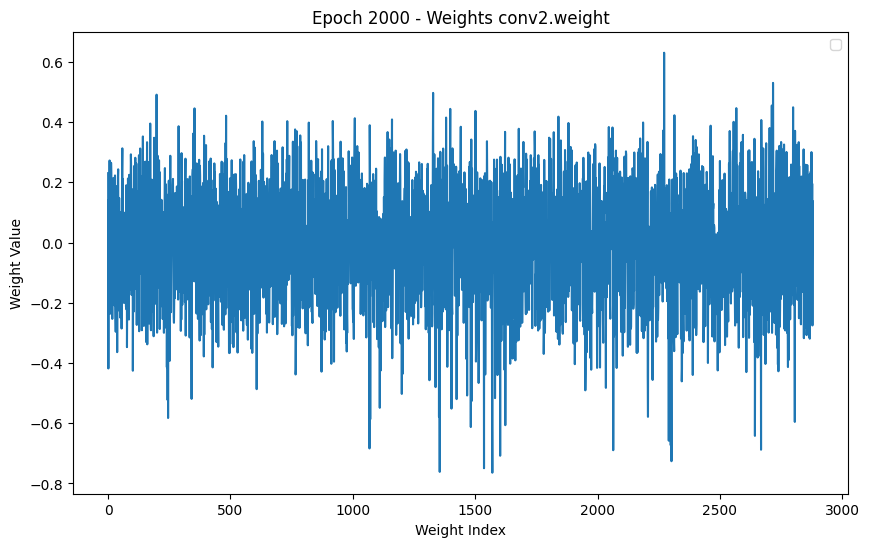

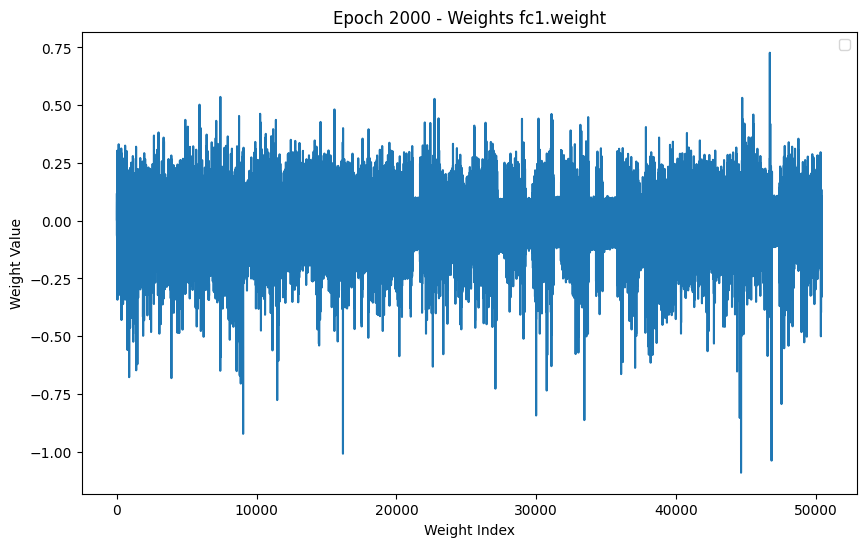

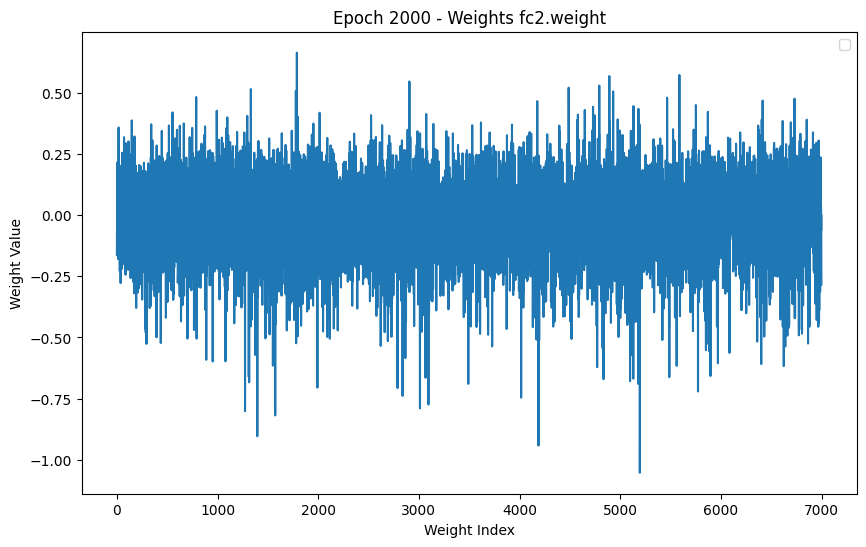

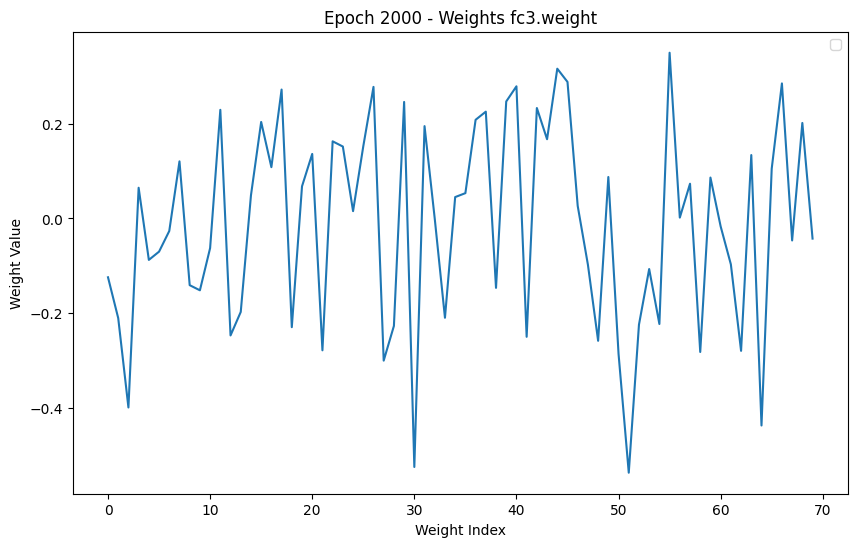

C:\Users\Sergio\AppData\Local\Temp\ipykernel_30220\3950198212.py:23: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc="upper right")


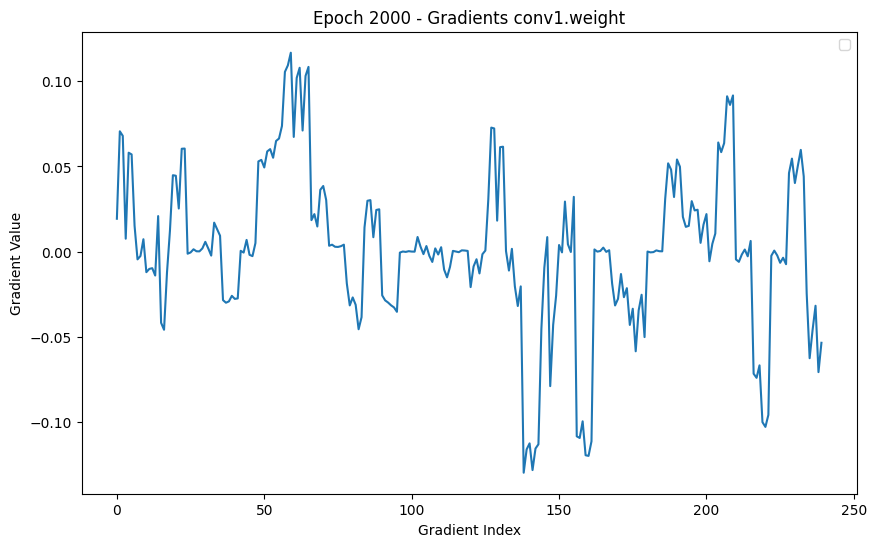

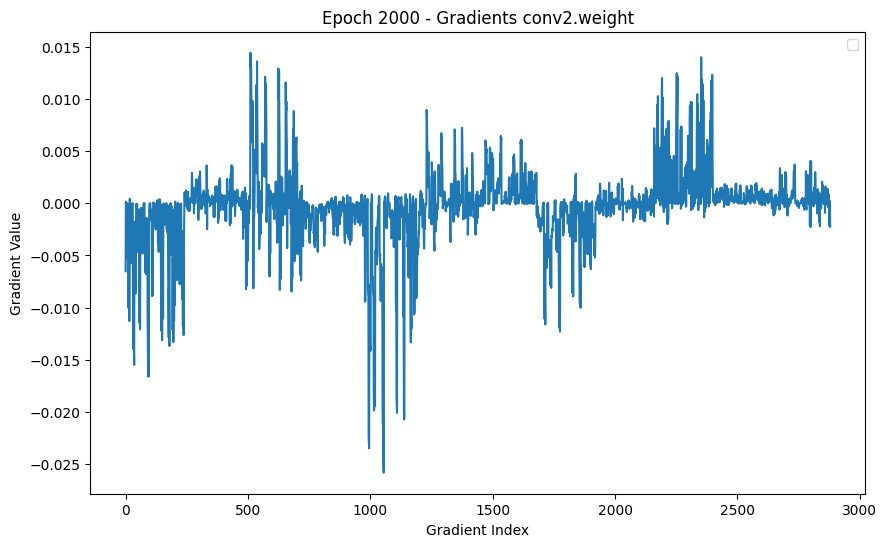

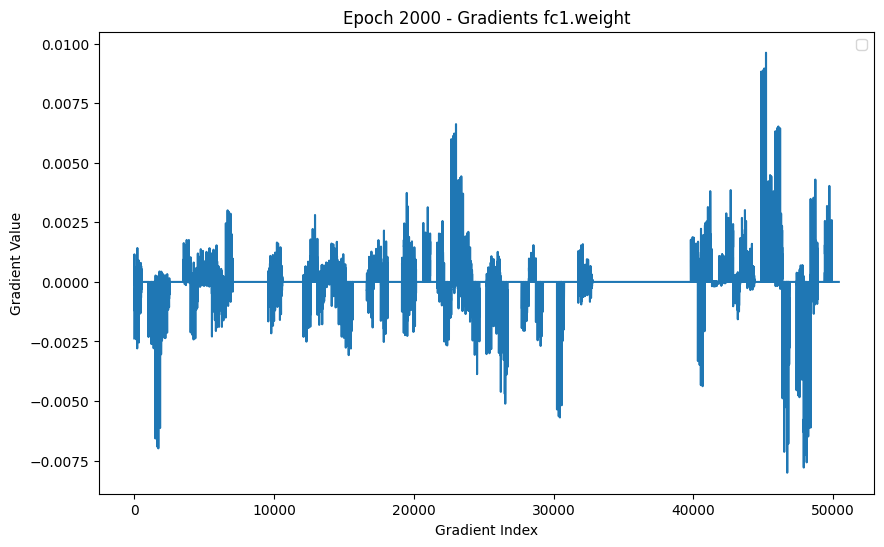

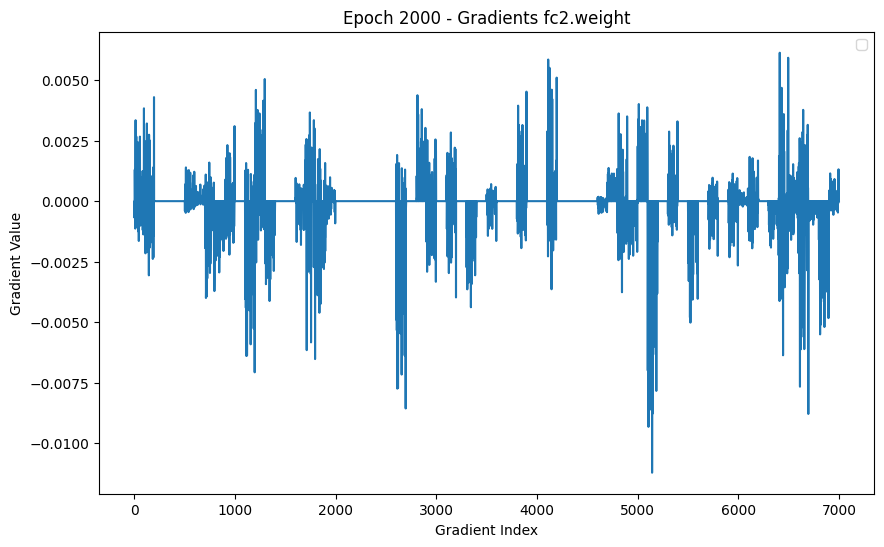

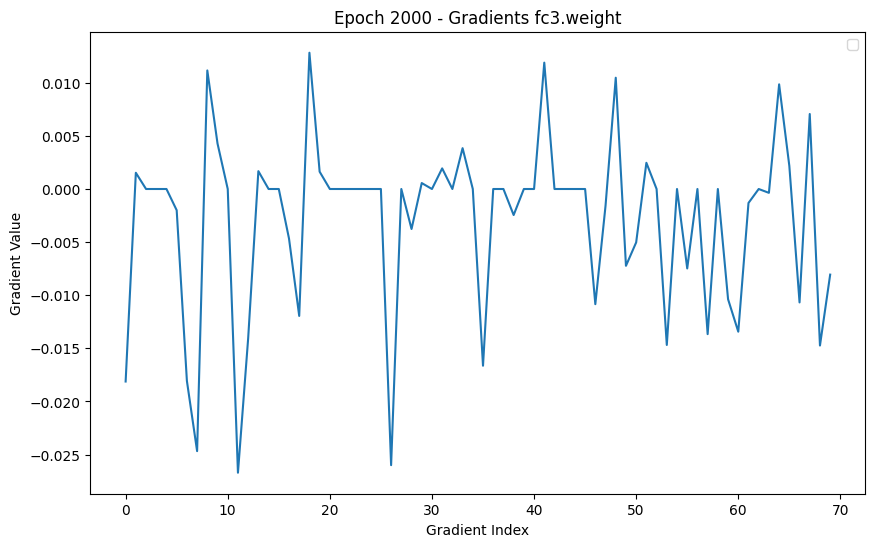

[2000,   384] Cum loss: 0.023932
[2400,   384] Cum loss: 0.023199
[2800,   384] Cum loss: 0.023222
[3200,   384] Cum loss: 0.022864
[3600,   384] Cum loss: 0.022863


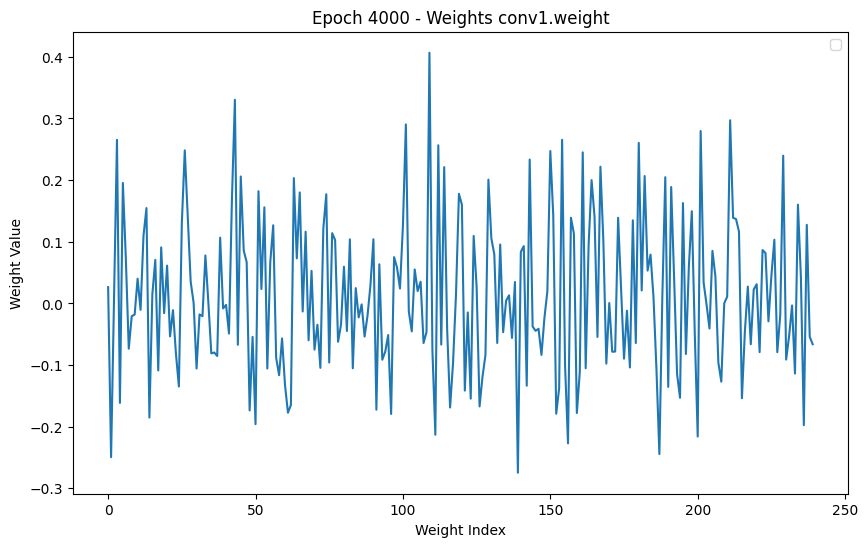

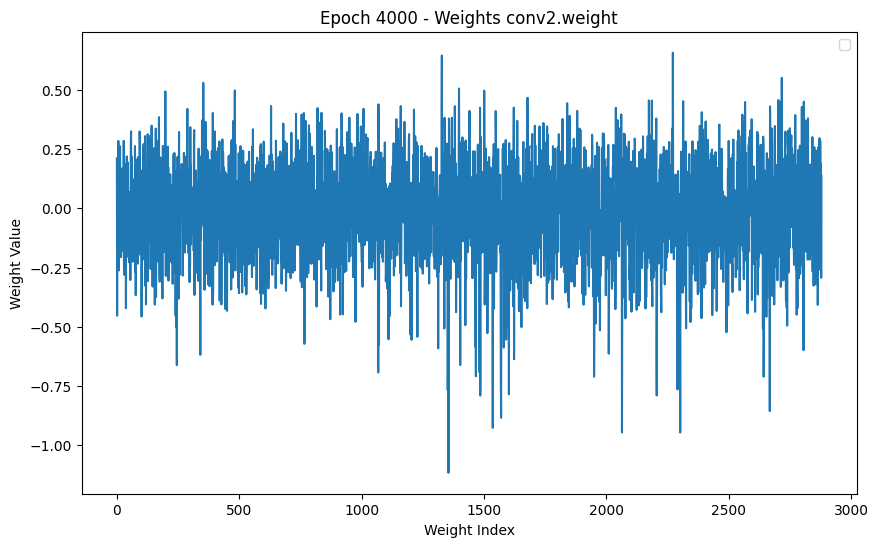

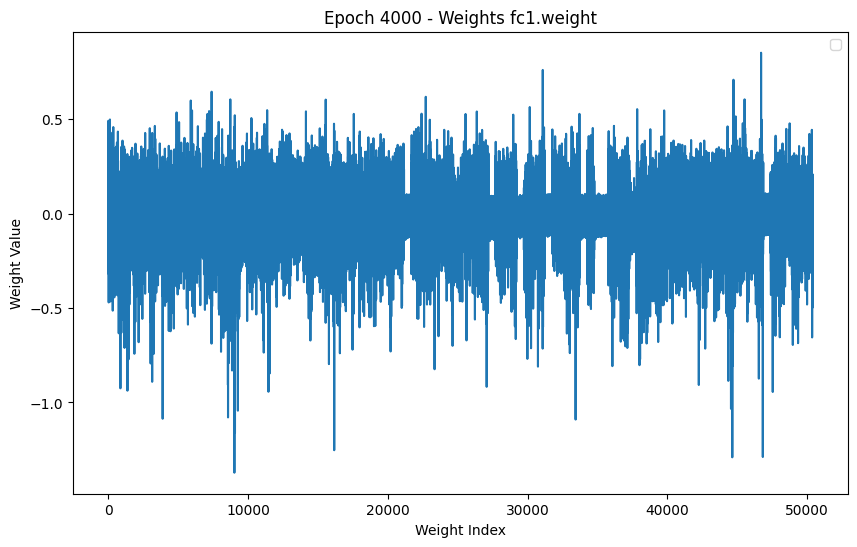

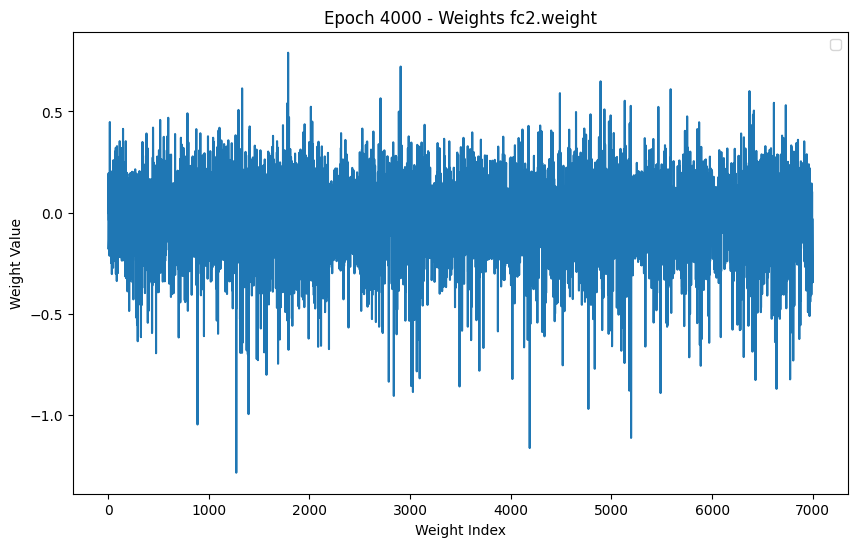

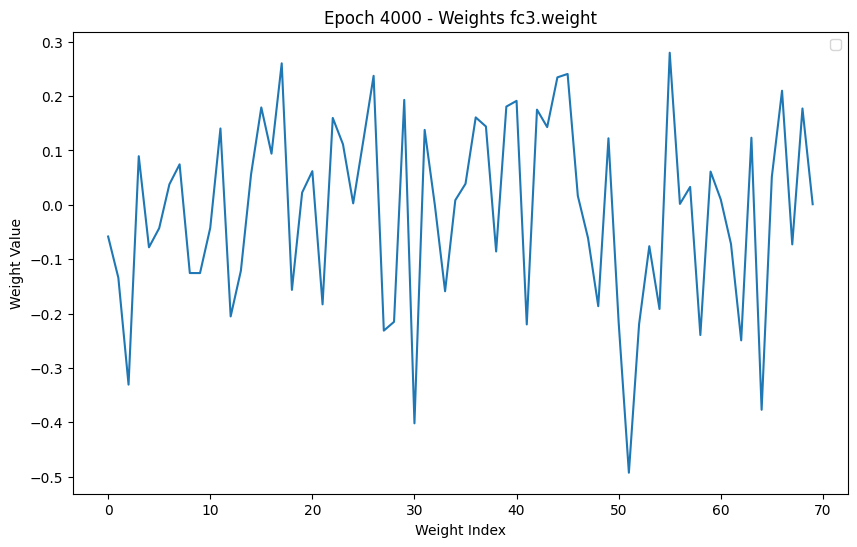

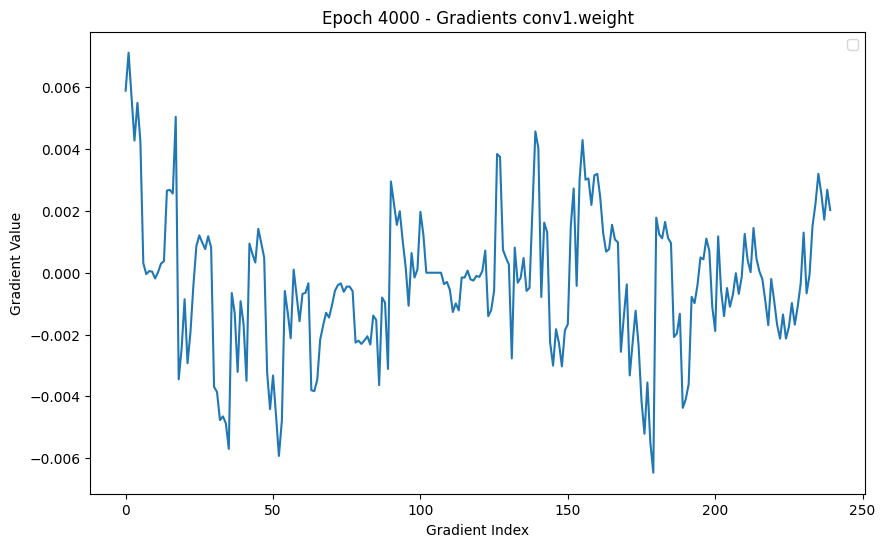

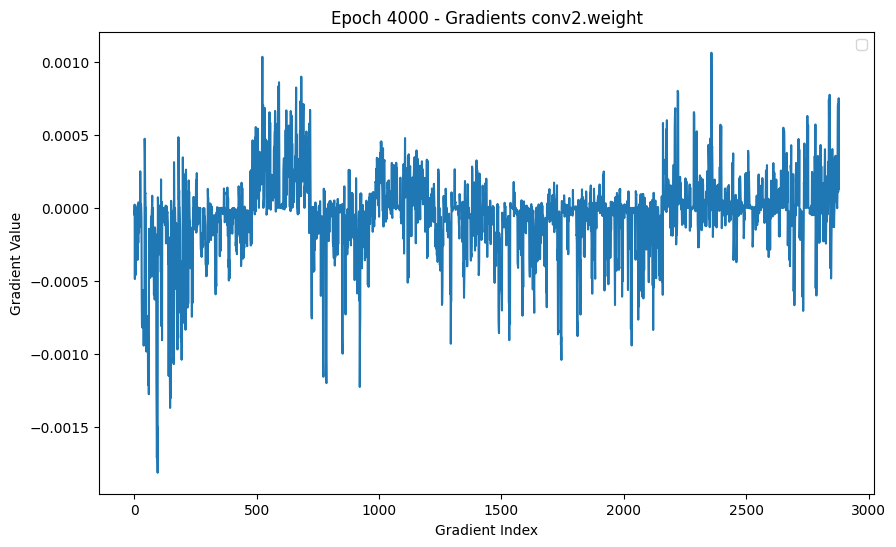

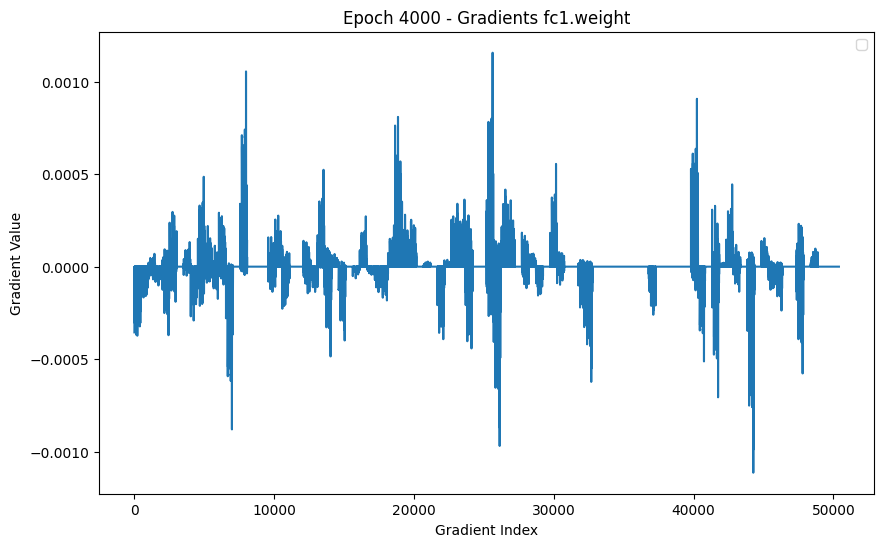

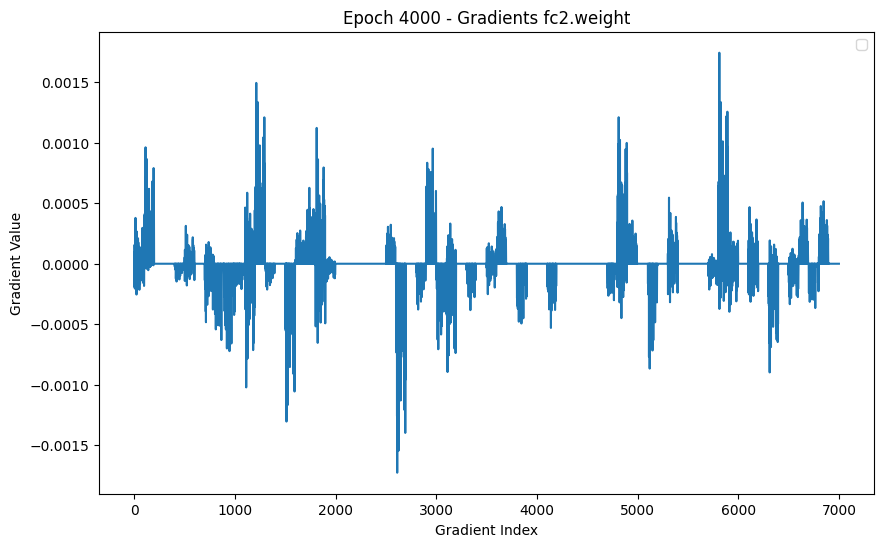

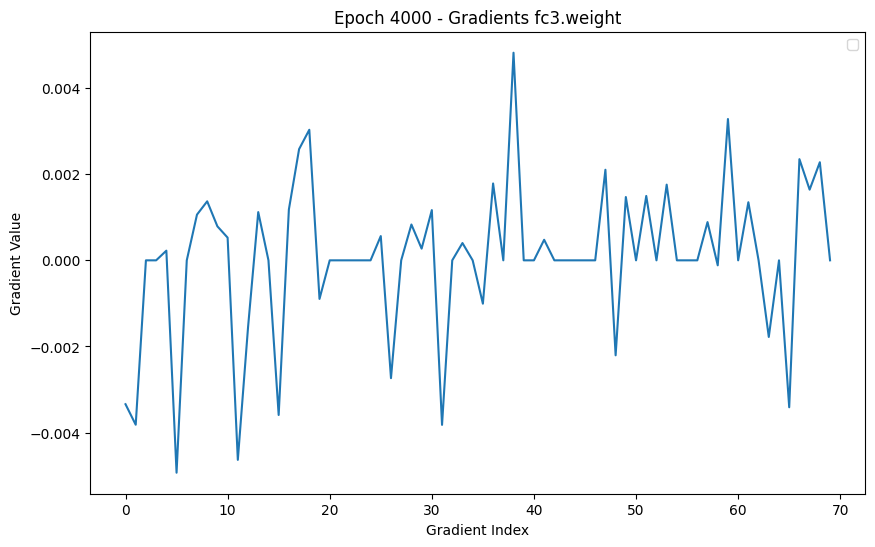

[4000,   384] Cum loss: 0.022615
[4400,   384] Cum loss: 0.022655
Loss is less than 0.000001:1.9458737199329335e-07 Stopping training.
tensor(1.9459e-07, device='cuda:0', grad_fn=<MseLossBackward0>)


In [114]:
#torch.set_printoptions(threshold=torch.inf)

#print running_loss every [x] mini-batches
mini_batch_running_loss_check = 384#38
epoch_running_loss_check = 400
epoch_running_gradients_check = 2000

def Train(learning_rate=learning_rate,momentum=momentum,
          train_loader=train_loader, net=net):
    
    start_time = time.time()

    print(f"Train params: learning_rate: {learning_rate}, momentum:{momentum}")

    net.apply(weights_init_he)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)
    #criterion = nn.CrossEntropyLoss()
    #optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=momentum)

    for epoch in range(num_epochs_input):

        gradients_dict = {name: [] for name, _ in net.named_parameters() if 'weight' in name}

        weights_dict = {name: [] for name, _ in net.named_parameters() if 'weight' in name}

        running_loss = 0.0

        first_batch = True
        
        for i, data in enumerate(train_loader, 0):
            #print(f"Batch {i + 1}")
            #get the inputs; data is a list of [inputs, labels]
            # print("image type",type(data[0]), "shape", data[0].shape)
            # print("image size",data[0].numel())
            # print("label type",type(data[1]), "shape", data[1].shape)
            # print("label size",data[1].numel())
            #print("**zero:",data[0])
            #print("type",type(data[1]),"**one:", data[1])
            #print("label pre",data[1])
            #data[1]=data[1].type(torch.LongTensor)
            inputs, labels = data[0].to(device), data[1].to(device)
            if i==0 and epoch==0:
                print("epoch",epoch,"data i",i,"len image",len(inputs), "shape",inputs.shape)
                print("epoch",epoch,"data i",i,"label",labels,"labels shape",labels.shape)
            
            # for e in data[1]:
            #     print("label",e.item())
            #print("label",data[1].item())
            #labels = labels.long()

            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backward + optimize
            outputs = net(inputs)
            #print("outputs",outputs)
            loss = criterion(outputs, labels)
            if loss is not None:
                loss.backward()
                optimizer.step()

                # Print optimizer's state_dict
                # print("Optimizer's state_dict:")
                # for var_name in optimizer.state_dict():
                #     print(var_name, "\t", optimizer.state_dict()[var_name])

                # print epoch/loss
                running_loss += loss.item()
                #if i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):    # print every x mini-batches
                #changed to show less results because with 10k epochs it cloggs github repo
                if (epoch+ 1) % epoch_running_loss_check == 0 and  i % mini_batch_running_loss_check == (mini_batch_running_loss_check-1):
                    print('[%d, %5d] Cum loss: %.6f' %
                        (epoch + 1, i + 1, running_loss / mini_batch_running_loss_check)) 
                    running_loss = 0.0

                if loss.item() < 0.000001:
                    print(f"Loss is less than 0.000001:{loss.item()} Stopping training.")
                    return loss
                
                if first_batch and ((epoch + 1) % epoch_running_gradients_check == 0):
                    for name, param in net.named_parameters():
                        if 'weight' in name:
                            if param.grad is not None:
                                gradients_dict[name].append(param.grad.detach().cpu().numpy())
                            weights_dict[name].append(param.detach().cpu().numpy())

                    plot_data(weights_dict, gradients_dict, epoch)
                    first_batch = False
                    #print("epoch",epoch,"data i",i,"image",inputs)
                    #print("epoch",epoch,"data i",i,"label",labels)
                    #print("epoch",epoch,"outputs i",i,"outputs",outputs)
    
    end_time = time.time()

    # Calculate elapsed time
    elapsed_time = end_time - start_time
    print(f"Elapsed time: {elapsed_time:.6f} seconds")
                
    return loss

loss = Train()
print(loss)

#torch.set_printoptions()

In [ ]:
Save_Scenario_Model(scenario,net)

## Test CNN Results

Test Results

In [119]:
def Test(test_loader=test_loader, net=net):
    predicted = []
    actual = []
    accuracy = 0
    correct_2dp = 0
    correct_1dp = 0
    correct_0dp = 0
    total = 0
    sum_diff = 0
    #dataframe vars
    predicted_np = []
    actual_np = []
    percentage_diff_np = []
    percentage_diffs = []

    for i, data in enumerate(test_loader, 0):
        inputs, labels = data[0].to(device), data[1].to(device)
        outputs = net(inputs)
        
        predicted.append(outputs)
        actual.append(labels)

        predicted_rounded = torch.round(outputs.data * 100) / 100
        actual_rounded = torch.round(labels.data * 100) / 100
        if i==0:
            print("predicted rounded",predicted_rounded,"actual rounded",actual_rounded)

        #calculate batch pct difference
        batch_absolute_diff = torch.abs(predicted_rounded - actual_rounded)
        #print("abs diff at",i," is:",batch_absolute_diff)
        batch_percentage_diff = (batch_absolute_diff / actual_rounded) * 100
        # accumulate sum of diffs
        sum_diff += torch.sum(batch_percentage_diff).item()

        #add to cumulative dataframe
        predicted_np.extend(predicted_rounded.cpu().detach().numpy().flatten())
        actual_np.extend(actual_rounded.cpu().detach().numpy().flatten())
        percentage_diffs.extend(batch_percentage_diff.cpu().detach().numpy().flatten())

        correct_2dp += torch.sum(torch.abs(predicted_rounded - actual_rounded) <= 0.01).item()
        correct_1dp += torch.sum(torch.abs(predicted_rounded - actual_rounded) <= 0.1).item()
        predicted_int = torch.floor(predicted_rounded).long()  # Use floor to truncate towards zero
        actual_int = torch.floor(actual_rounded).long()
        correct_0dp += torch.sum(torch.abs(predicted_int == actual_int)).item()

        total += len(predicted_rounded)

    #Pct correct pred
    accuracy_2dp = (correct_2dp / total) * 100
    accuracy_1dp = (correct_1dp / total) * 100
    accuracy_0dp = (correct_0dp / total) * 100

    #total pct difference
    mean_percentage_diff = (abs(sum_diff) / total)

    print(f"Percentage of predictions within "
          f"2 decimal places: {accuracy_2dp:.2f}%, "
          f"1 decimal places: {accuracy_1dp:.2f}%, "
          f"0 decimal places: {accuracy_0dp:.2f}%, "
          f"and mean % Diff:{mean_percentage_diff:.2f}%")
        
    accuracy = [accuracy_0dp,accuracy_1dp,accuracy_2dp]

    #print(predicted,actual)
    return predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff

In [120]:
def Test_And_Report(net=net):

    predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff = Test(net=net)

    # predicted_np = predicted.cpu().detach().numpy()
    # actual_np = actual.cpu().detach().numpy()
    # percentage_diff_np = percentage_diff.cpu().detach().numpy()

    # Create a dictionary with the data
    data = {
        'Predicted': predicted_np,
        'Actual': actual_np,
        'Percentage Difference': percentage_diffs
    }

    # Create the DataFrame
    df = pd.DataFrame(data)
    df['Percentage Difference'] = df['Percentage Difference'].map(lambda x: f"{x:.3f}%")

    pd.set_option('display.max_rows', None)
    #print(df)
    pd.reset_option('display.max_rows')

    df['Percentage Difference'] = df['Percentage Difference'].str.rstrip('%').astype(float)

    average_percentage_diff = df['Percentage Difference'].mean()

    return predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff, average_percentage_diff, df


predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff, average_percentage_diff, df = Test_And_Report(net)


predicted rounded tensor([[-0.6100],
        [-0.7600],
        [ 0.4200],
        [ 1.0400],
        [ 0.2500]], device='cuda:0') actual rounded tensor([[-2.4700],
        [ 0.0300],
        [ 0.2700],
        [ 1.3600],
        [ 0.2500]], device='cuda:0')
Percentage of predictions within 2 decimal places: 16.46%, 1 decimal places: 39.79%, 0 decimal places: 68.75%, and mean % Diff:111.76%


In [ ]:
#write to file
output_string = (f"Accuracy 2dp: {accuracy[2]:.3f}"
                 f"Accuracy 1dp: {accuracy[1]:.3f}"
                 f"Accuracy 0dp: {accuracy[0]:.3f}"
                 f"Average Percentage Difference: "
                 f"{average_percentage_diff:.3f}% for timeseries of {len(df)} "
                 f"datapoints across {len(cols_used)} features: {cols_used}.")

Scenario_Log(output_string)
print(output_string)

Accuracy: 1.250 Average Percentage Difference: 80.872% for timeseries of 480 datapoints across 5 features: ['Open', 'High', 'Low', 'Close', 'Adj Close'].


## Bayesian Optimization for CNN Hyperparameters

In [121]:
def CNN_Optimization(output_conv_1, 
                     output_conv_2,
                     dropout_probab,
                     learning_rate,
                     momentum,
                     train_loader,test_loader,
                     iteration=None):
    
    output_conv_1 = int(output_conv_1)
    output_conv_2 = int(output_conv_2)
    
    net = Net(output_conv_1=output_conv_1, output_conv_2=output_conv_2,dropout_probab=dropout_probab)
    net.to(device)

    Train(learning_rate=learning_rate, train_loader=train_loader, net=net, momentum=momentum)

    if iteration is not None:
        Save_BayesOpt_Model(iteration,net)

    predicted, actual, accuracy, percentage_diffs, mean_percentage_diff = Test(test_loader=test_loader,net=net)
    
    print("accuracy received",accuracy)

    return accuracy

In [122]:
from bayes_opt import BayesianOptimization
#from functools import partial

def Optimize():
    
    Generate_Train_And_Test_Loaders(feature_image_dataset_list_f32,labels_scaled_list_f32, train_shuffle=False, batch_size=batch_size)
    
    iteration_counter = [0]

    def cnn_correct_pct_wrapper(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum):
        result = CNN_Optimization(output_conv_1, output_conv_2, learning_rate, dropout_probab, momentum, train_loader, test_loader, iteration=iteration_counter[0])
        iteration_counter[0] += 1
        return result
    #cnn_correct_pct = partial(CNN_Optimization, train_loader = train_loader, test_loader = test_loader)

    # Bounded region of parameter space
    pbounds = {'output_conv_1': (40, 80),
               'output_conv_2': (8, 16), 
               'learning_rate': (0.00001, 0.0001), 
               'dropout_probab': (0.0, 0.5), 
               'momentum': (0.8, 1.0)}

    optimizer = BayesianOptimization(
        f = cnn_correct_pct_wrapper,
        pbounds=pbounds,
        random_state=1,
        )

    #n_iter:steps of bayesian optimization you want to perform
    #init_points:steps of random exploration
    optimizer.maximize(init_points=10, n_iter=10,)

    with open(f'optimizer_results.txt', 'a') as file:
        for i, res in enumerate(optimizer.res):
            print(f"Iteration {i}: \n\t{res}")
            file.write("\n\nIteration {}: \n\t{}".format(i, res))

    optimizer_max_result = optimizer.max
    print("optimizer result:\n",optimizer.max)

    with open(f'optimizer_results.txt', 'a') as file:
        file.write('\noptimizer results:\n' + str(optimizer_max_result))

In [ ]:
# comment out to not run bayesian opt
#Optimize()

In [ ]:
# example to reconstruct Net model design. Enter optimizer_results.txt scenario variable results used to validate the net design model inference result matches the optimizer_results.txt output
# dropout_probab = 0.4473033317519236
# learning_rate = 1.7653979023280013e-05
# momentum = 0.8078109566465765
# output_conv_1 = int(46.7)
# output_conv_2 = int(15.0)

# net = Net(name='Classification Net', filter_size_1=filter_size_1, filter_size_2=filter_size_2,
#             filter_size_3=filter_size_3, stride=stride,
#             image_resolution_x=32,image_resolution_y=32,
#             output_conv_1=output_conv_1, output_conv_2=output_conv_2,
#             output_FC_1=output_FC_1, output_FC_2=output_FC_2,
#             final_FCLayer_outputs=final_FCLayer_output,
#             dropout_probab=dropout_probab)

# net.to(device)
# net.parameters()

# net = Load_BayesOpt_Model("5",net)

# predicted_np, actual_np, accuracy, percentage_diffs, mean_percentage_diff, average_percentage_diff, df = Test_And_Report(net)
